<a href="https://colab.research.google.com/github/hardiksharma2005/Time-series-forcasting/blob/main/Time_Series_Forcasting_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Day 1



In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [186]:
# Loading data
df = pd.read_csv('stock_data.csv', parse_dates=['Date'], index_col='Date')

In [187]:
# Data preprocessing
data = df[['Close']].copy()
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
data.dropna(inplace=True)
data.sort_index(inplace=True)

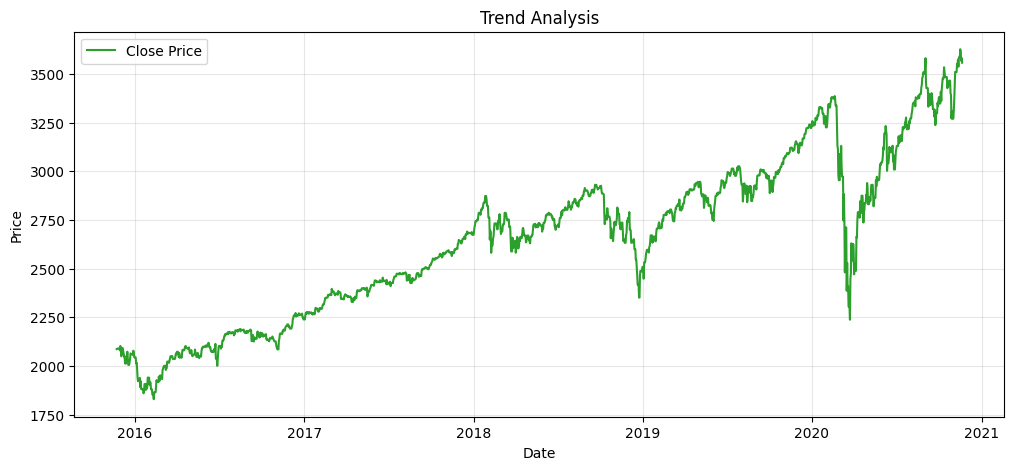

In [188]:
# EDA & visualization
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Close'], label='Close Price', color='#2ca02c')
plt.title("Trend Analysis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

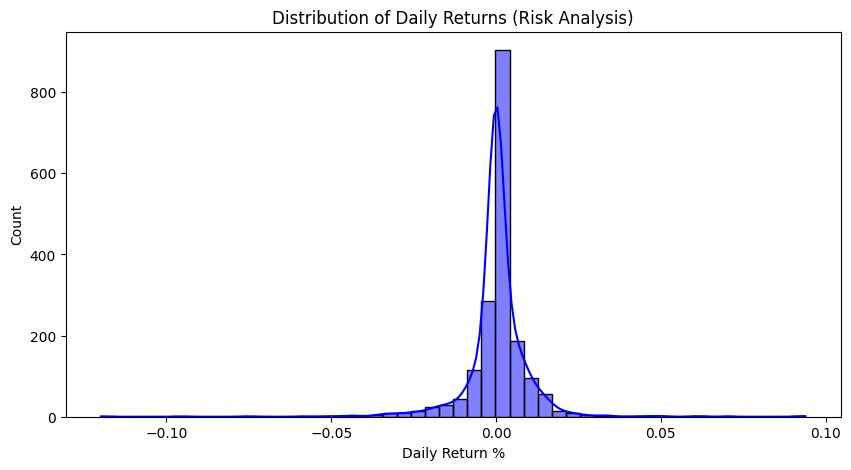

In [189]:
# Visualization of the trend
data['Daily_Return'] = data['Close'].pct_change()

plt.figure(figsize=(10, 5))
sns.histplot(data['Daily_Return'].dropna(), bins=50, kde=True, color='blue')
plt.title("Distribution of Daily Returns (Risk Analysis)")
plt.xlabel("Daily Return %")
plt.show()

Day 2

In [190]:
# calculating moving averages
# Shows short-term sentiment.
data['MA_50'] = data['Close'].rolling(window=50).mean()

# Shows the major long-term trend.
data['MA_200'] = data['Close'].rolling(window=200).mean()

In [191]:
# calculating volatility
data['Volatility'] = data['Close'].rolling(window=20).std()
data['Daily_Return'] = data['Close'].pct_change()

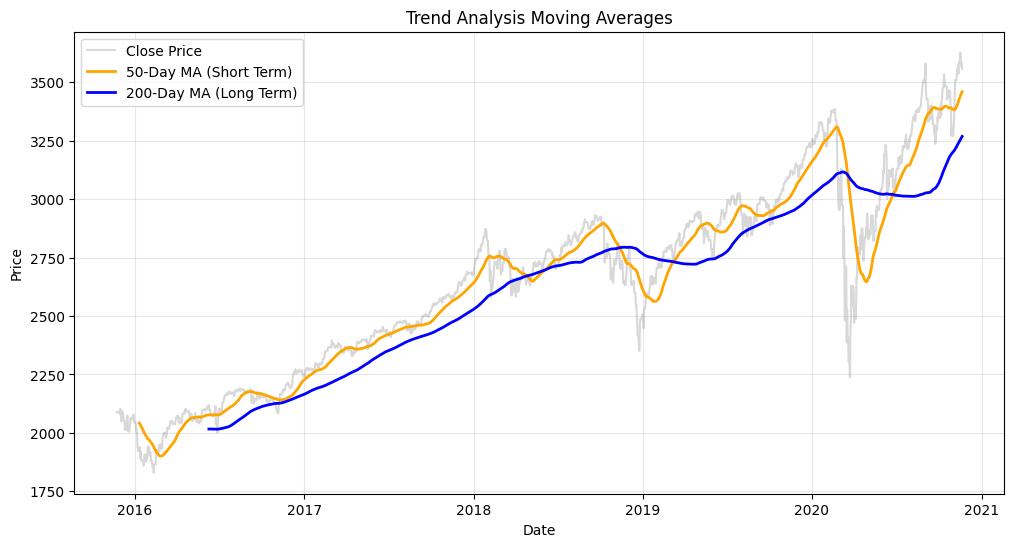

In [192]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.3, color='gray')

# Plotting MAs
plt.plot(data.index, data['MA_50'], label='50-Day MA (Short Term)', color='orange', linewidth=2)
plt.plot(data.index, data['MA_200'], label='200-Day MA (Long Term)', color='blue', linewidth=2)

plt.title("Trend Analysis Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

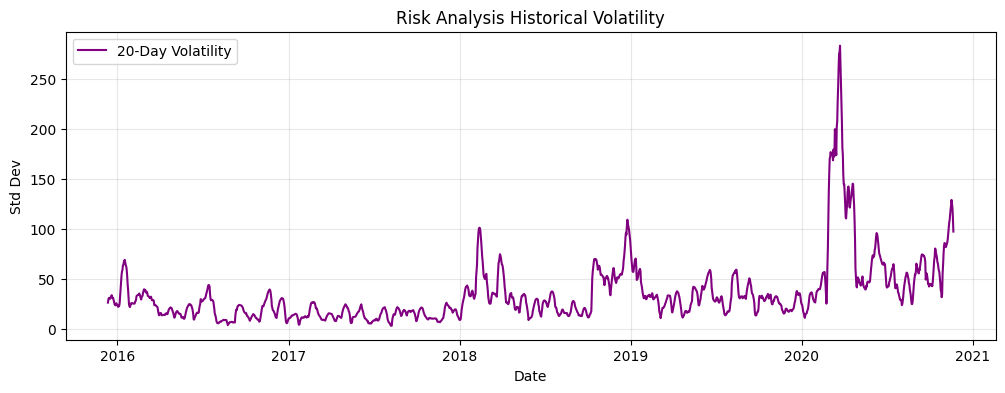

In [193]:
# Plotting the risk
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Volatility'], label='20-Day Volatility', color='purple')
plt.title("Risk Analysis Historical Volatility")
plt.xlabel("Date")
plt.ylabel("Std Dev")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

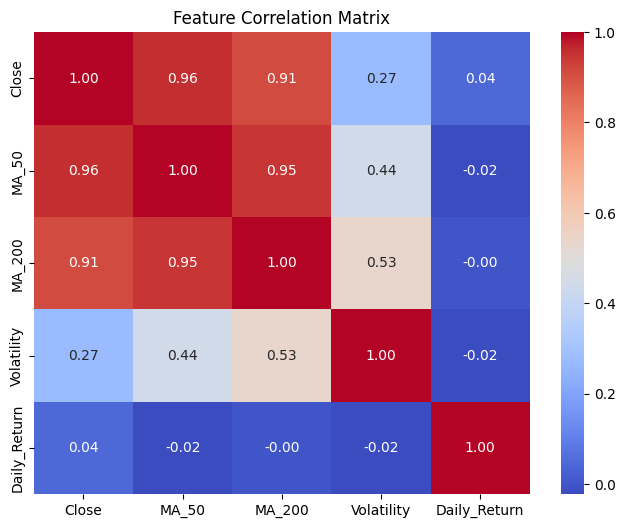

In [194]:
plt.figure(figsize=(8, 6))
correlation_data = data[['Close', 'MA_50', 'MA_200', 'Volatility', 'Daily_Return']].dropna()
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

Day 3

In [196]:
# The Stationarity Test (ADF)
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test {title}')
    result = adfuller(series.dropna())

    print(f'   ADF Statistic: {result[0]:.4f}')
    print(f'   p-value: {result[1]:.4f}')

    if result[1] <= 0.05:
        print("Data is Stationary (p <= 0.05). Ready for modeling")
        return True
    else:
        print("Data is Non-Stationary (p > 0.05). It has a trend")
        return False

is_stationary = adf_test(data['Close'], "Original Close Price")

Augmented Dickey-Fuller Test Original Close Price
   ADF Statistic: -0.8704
   p-value: 0.7976
Data is Non-Stationary (p > 0.05). It has a trend


Augmented Dickey-Fuller Test Differenced Data
   ADF Statistic: -8.5222
   p-value: 0.0000
Data is Stationary (p <= 0.05). Ready for modeling


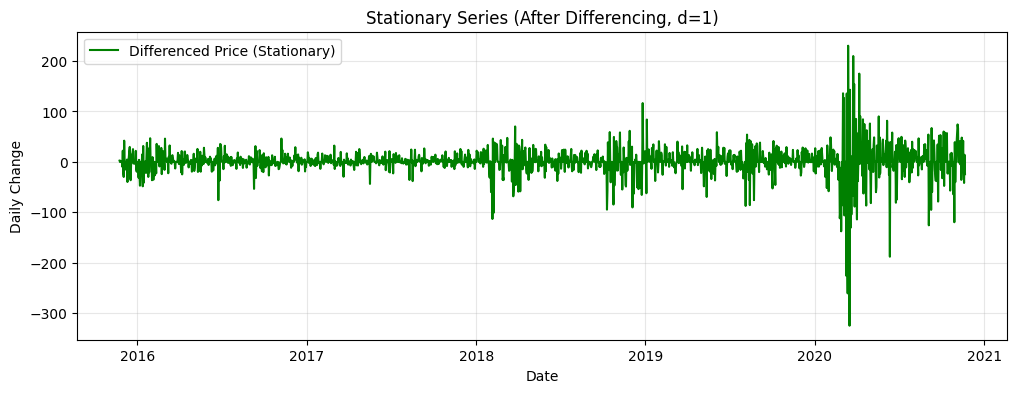

In [197]:
# Differencing
d = 0
if not is_stationary:
    data['Diff'] = data['Close'].diff()
    d = 1

    adf_test(data['Diff'], "Differenced Data")

# Plot the "Stationary" Data
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Diff'], label='Differenced Price (Stationary)', color='green')
plt.title(f"Stationary Series (After Differencing, d={d})")
plt.xlabel("Date")
plt.ylabel("Daily Change")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

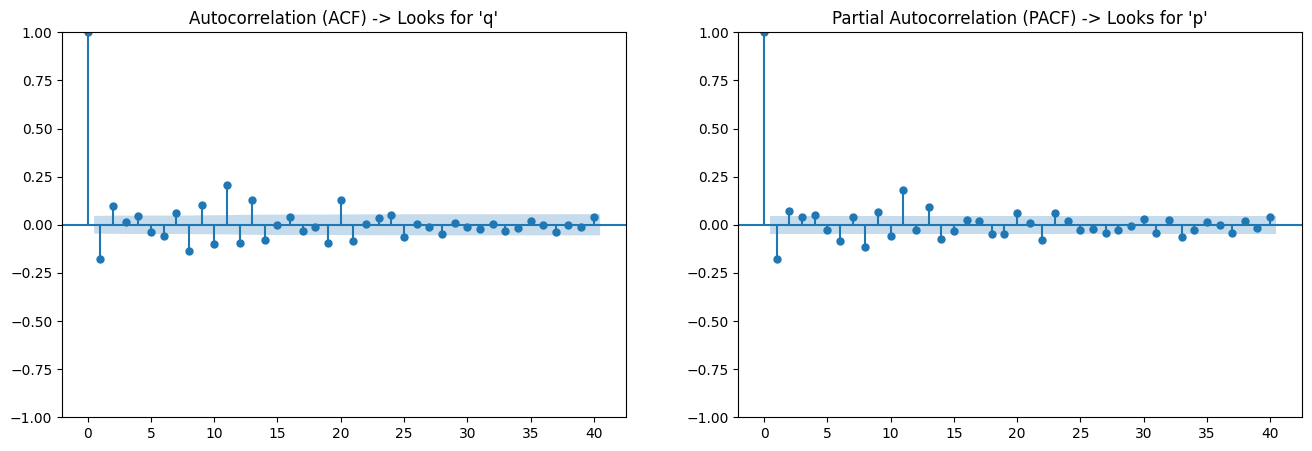

In [198]:
# Finding p and q (ACF/PACF)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# ACF Plot
plot_acf(data['Diff'].dropna(), ax=ax1, lags=40)
ax1.set_title("Autocorrelation (ACF) -> Looks for 'q'")

# PACF Plot
plot_pacf(data['Diff'].dropna(), ax=ax2, lags=40)
ax2.set_title("Partial Autocorrelation (PACF) -> Looks for 'p'")

plt.show()

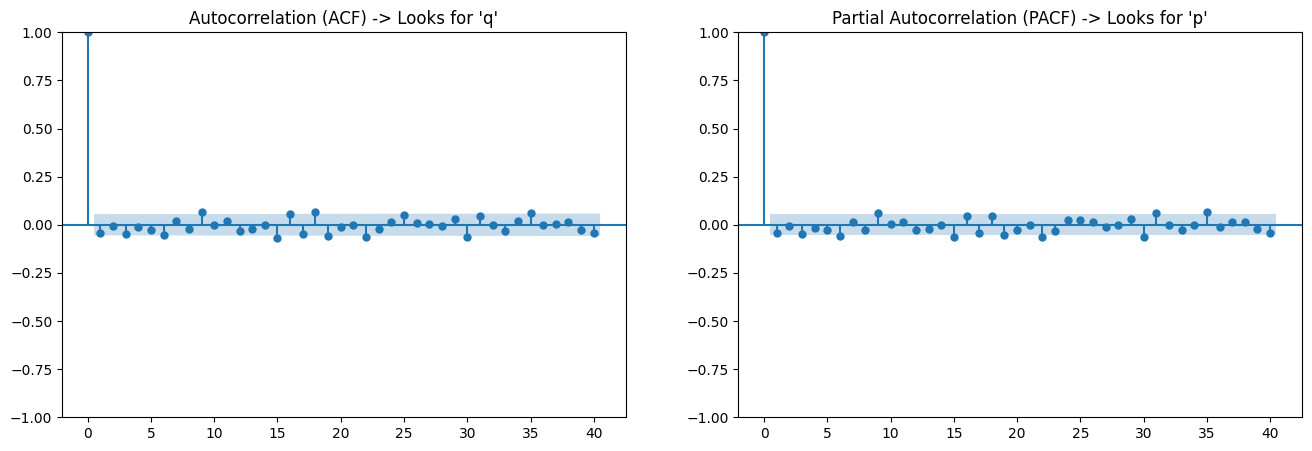

In [126]:
# Finding p and q (ACF/PACF)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# ACF plot
plot_acf(data['Diff'].dropna(), ax=ax1, lags=40)
ax1.set_title("Autocorrelation (ACF) -> Looks for 'q'")

# PACF plot
plot_pacf(data['Diff'].dropna(), ax=ax2, lags=40)
ax2.set_title("Partial Autocorrelation (PACF) -> Looks for 'p'")

plt.show()

Day 4

In [207]:
# Training and Testing data setup
test_days = 30
train_data = data['Close'].iloc[:-test_days]
test_data = data['Close'].iloc[-test_days:]

print(f"Training on {len(train_data)} days")
print(f"Testing on {len(test_data)} days")

Training on 1795 days
Testing on 30 days


In [210]:
# Building & Training Model
model = ARIMA(train_data, order=(1,1,1))
model_fit = model.fit()

forecast_result = model_fit.forecast(steps=len(test_data))

# Assign the dates to the result so we can plot it
forecast_series = pd.Series(forecast_result.values, index=test_data.index)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [211]:
mape = mean_absolute_percentage_error(test_data, forecast_series)

print(f"MAPE Score: {mape * 100:.2f}%")

MAPE Score: 3.01%


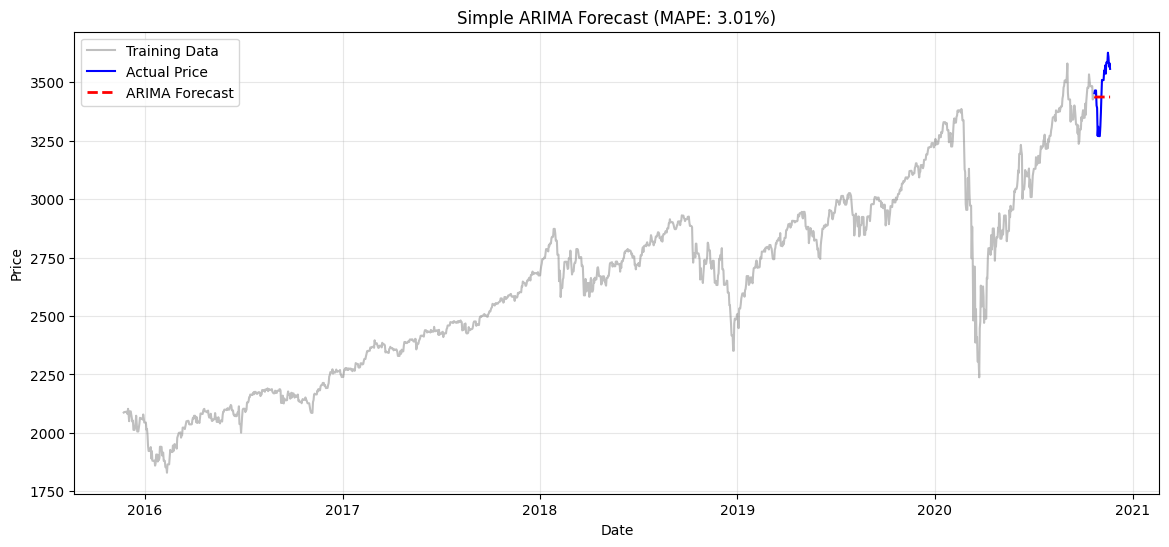

In [213]:
# Visualization
plt.figure(figsize=(14, 6))

plt.plot(train_data.index, train_data, label='Training Data', color='gray', alpha=0.5)

plt.plot(test_data.index, test_data, label='Actual Price', color='blue')

plt.plot(forecast_series.index, forecast_series, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)

plt.title(f"Simple ARIMA Forecast (MAPE: {mape*100:.2f}%)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()